In [1]:
# ------------------- CELULA 1: Setup Environment and Load Libraries -------------------
!pip install pandas numpy scipy statsmodels openpyxl

import pandas as pd


In [2]:
# ------------------- CELULA 2: Load DataFrame from CSV -------------------
# Use forward slashes para evitar problemas de escape
df = pd.read_csv(r"D:\PhD_Jupyter\files\data\clean_data\measures_phd_valid.csv", low_memory=False)
print("Loaded DataFrame shape:", df.shape)
display(df.head())


Loaded DataFrame shape: (108, 30)


,ID_codes,Strategy,Group,JOSE,words_recalled,categorical_access,IPCA,R,expectedR,maxR,...,recog_target_rt,recog_unrelated_score,recog_unrelated_rt,recog_related_score,recog_related_rt,nback_score,nback_rt_mean,cycle_2,cycle_4,cycle_6
0,100614101,1,0,1,25,7,3.571,12,2.800,18,...,0.764,20,0.952,19,0.877,44,1.717,15,23,29
1,103484010,0,1,0,16,6,2.667,6,2.250,10,...,1.004,20,0.890,19,1.230,58,1.134,0,0,0
2,106977011,0,1,1,23,7,3.286,7,2.783,16,...,1.055,19,1.297,18,1.377,49,1.581,0,0,0
3,126855010,0,1,0,23,8,2.875,10,2.435,15,...,1.219,18,1.899,20,1.292,59,1.066,0,0,0
4,128492111,1,1,1,26,7,3.714,12,2.846,19,...,0.811,20,0.756,20,0.975,58,0.948,17,28,36


In [3]:
# ------------------- CELULA 3: Analysis from analises_memoria.py (updated) -------------------
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Estatísticas descritivas por grupo e estratégia
desc = df.groupby(["Group", "Strategy"])[["words_recalled", "categorical_access"]].describe()
print("\nEstatísticas descritivas:\n", desc)

# ANOVA mista para ciclos
long_df = pd.melt(df, id_vars=['ID_codes', 'Group', 'Strategy'],
                  value_vars=['cycle_2', 'cycle_4', 'cycle_6'],
                  var_name='Cycle', value_name='WordsRecalled')
model_cycles = ols('WordsRecalled ~ C(Cycle) * C(Group) * C(Strategy)', data=long_df).fit()
print("\nANOVA - Ciclos de aprendizagem:\n", sm.stats.anova_lm(model_cycles, typ=2))

# ANOVA para ARC
model_arc = ols('categorical_access ~ C(Group) * C(Strategy)', data=df).fit()
print("\nANOVA - ARC:\n", sm.stats.anova_lm(model_arc, typ=2))

# ANOVA para tempo de reação
model_rt = ols('recog_target_rt ~ C(Group) * C(Strategy)', data=df).fit()
print("\nANOVA - Tempo de Reação:\n", sm.stats.anova_lm(model_rt, typ=2))

# Testes t para BAIdelta e PANASdelta
print("\nT-TESTES entre grupos para deltas:")
print("BAI Δ (delta):", stats.ttest_ind(df[df['Group'] == 0]['BAIdelta'],
                                      df[df['Group'] == 1]['BAIdelta'], nan_policy='omit'))
print("PANAS Δ (delta):", stats.ttest_ind(df[df['Group'] == 0]['PANASdelta'],
                                         df[df['Group'] == 1]['PANASdelta'], nan_policy='omit'))

# Correlações
corr_vars = df[['BAIdelta', 'PANASdelta', 'words_recalled', 'categorical_access']]
print("\nCorrelação entre variáveis:\n", corr_vars.corr(method='pearson'))



Estatísticas descritivas:
                words_recalled                                                \
                        count       mean       std   min   25%   50%    75%   
Group Strategy                                                                
0     0                  24.0  20.166667  6.458339   9.0  17.0  20.0  22.25   
      1                  27.0  25.407407  7.196470  11.0  20.5  27.0  31.00   
1     0                  29.0  20.517241  8.559125   6.0  14.0  21.0  24.00   
      1                  28.0  25.571429  8.850313   7.0  19.0  26.0  32.50   

                     categorical_access                                     \
                 max              count      mean       std  min  25%  50%   
Group Strategy                                                               
0     0         36.0               24.0  6.500000  1.215838  4.0  6.0  6.0   
      1         36.0               27.0  7.222222  0.891556  5.0  7.0  7.0   
1     0         38.0        

In [7]:
# ------------------- CELULA FINAL: Run full analysis suite and save results -------------------
import pandas as pd, numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

assert 'df' in globals(), "Execute as células de carregamento antes!"

# ------------------------------------------------------------------
# 1) GARANTIR COLUNA JOSE (0 = pré-teste, 1 = pós-teste)
# ------------------------------------------------------------------
if 'JOSE' not in df.columns:
    df['JOSE'] = df['ID_codes'].astype(str).str[-1].astype(int)

# ------------------------------------------------------------------
# 2) CRIAR LONG_DF PARA ANOVA DE CICLOS (incluindo JOSE)
# ------------------------------------------------------------------
long_df = pd.melt(
    df,
    id_vars=['ID_codes', 'Group', 'Strategy', 'JOSE'],
    value_vars=['cycle_2', 'cycle_4', 'cycle_6'],
    var_name='Cycle',
    value_name='WordsRecalled'
)

# ------------------------------------------------------------------
# 3) EXECUTAR TODAS AS ANÁLISES
# ------------------------------------------------------------------
results = {}

# A1 Descrições
results["A1_Descriptives"] = (
    df.groupby(["Group", "Strategy"])[["words_recalled", "categorical_access"]]
      .describe()
)

# A2 ANOVA mista 3×2×2
results["A2_Mixed_ANOVA_Cycles"] = sm.stats.anova_lm(
    ols('WordsRecalled ~ C(Cycle)*C(Group)*C(Strategy)', data=long_df).fit(), typ=2
)

# A3 ARC ANOVA
results["A3_ARC_ANOVA"] = sm.stats.anova_lm(
    ols('categorical_access ~ C(Group)*C(Strategy)', data=df).fit(), typ=2
)

# A4 RT ANOVA
results["A4_RT_ANOVA"] = sm.stats.anova_lm(
    ols('recog_target_rt ~ C(Group)*C(Strategy)', data=df).fit(), typ=2
)

# A5 t-tests nos deltas
tt_bai   = stats.ttest_ind(df[df.Group==0]['BAIdelta'],   df[df.Group==1]['BAIdelta'],   nan_policy='omit')
tt_panas = stats.ttest_ind(df[df.Group==0]['PANASdelta'], df[df.Group==1]['PANASdelta'], nan_policy='omit')
results["A5_t_BAIdelta"]   = pd.DataFrame({'t':[tt_bai.statistic],   'p':[tt_bai.pvalue],   'df':[tt_bai.df]})
results["A5_t_PANASdelta"] = pd.DataFrame({'t':[tt_panas.statistic], 'p':[tt_panas.pvalue], 'df':[tt_panas.df]})

# A6 Modelos preditivos JOSE
results["A6_JOSE_WR"]  = sm.stats.anova_lm(ols('words_recalled      ~ JOSE*Strategy*Group', data=df).fit(), typ=2)
results["A6_JOSE_ARC"] = sm.stats.anova_lm(ols('categorical_access ~ JOSE*Strategy*Group', data=df).fit(), typ=2)

# A7 Interação 3-vias em ciclos
results["A7_JOSExStrategyxGroup"] = sm.stats.anova_lm(
    ols('WordsRecalled ~ JOSE*Strategy*Group', data=long_df).fit(), typ=2
)

# ---------- A8 Mixed-effects model cycles ----------
md = smf.mixedlm("WordsRecalled ~ C(Cycle)*C(Group)*C(Strategy)",
                 long_df, groups=long_df["ID_codes"])
mdf = md.fit(reml=False)

# Dependendo da versão, summary().tables[1] pode ser um SimpleTable ou um DataFrame.
me_table = mdf.summary().tables[1]
if isinstance(me_table, pd.DataFrame):
    me_df = me_table
else:  # SimpleTable → converter via HTML
    me_df = pd.read_html(me_table.as_html(), header=0, index_col=0)[0]

results["A8_Mixed_Effects"] = me_df


# ---------- A9 Curva de aprendizagem (quadrática) ----------
# Se 'Cycle' já é numérica (2, 4, 6), use diretamente; caso contrário, extraia dígito
if pd.api.types.is_numeric_dtype(long_df["Cycle"]):
    long_df["cycle_idx"] = long_df["Cycle"].astype(int)
else:
    long_df["cycle_idx"] = (
        pd.to_numeric(long_df["Cycle"].str.extract(r"(\\d+)")[0], errors="coerce")
    )

# Remover linhas sem índice válido
long_df = long_df.dropna(subset=["cycle_idx"])
long_df["cycle_idx"] = long_df["cycle_idx"].astype(int)

# Ajuste quadrático somente se houver ≥ 3 pontos distintos
if long_df["cycle_idx"].nunique() >= 3:
    poly = np.poly1d(
        np.polyfit(long_df["cycle_idx"], long_df["WordsRecalled"], 2)
    )
    coeff_df = pd.DataFrame(poly.c, index=["a2", "a1", "a0"], columns=["coef"])
else:
    coeff_df = pd.DataFrame(
        {"coef": ["N/A - dados insuficientes"]}, index=["info"]
    )

results["A9_LearningCurve_coeffs"] = coeff_df


# A10 Correlações
results["A10_Correlations"] = df[
    ['BAIdelta', 'PANASdelta', 'words_recalled', 'categorical_access']
].corr()

# ------------------------------------------------------------------
# 4) SALVAR TODOS OS DATAFRAMES NO EXCEL (TRATANDO MULTIINDEX)
# ------------------------------------------------------------------
output_file = r"D:\PhD_Jupyter\files\data\analysis\analysis_results.xlsx"
with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for name, table in results.items():
        sheet = name[:31]
        if isinstance(table.columns, pd.MultiIndex):
            flat = table.copy()
            flat.columns = ["_".join(map(str, lvl)).strip() for lvl in flat.columns.values]
            flat.to_excel(writer, sheet_name=sheet, index=True)
        else:
            table.to_excel(writer, sheet_name=sheet, index=True)

print(f"analysis_results.xlsx salvo com {len(results)} abas.")


analysis_results.xlsx salvo com 12 abas.


In [10]:
# ------------------- CELULA EXTRA: Add numeric summaries to each sheet -------------------
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
import numpy as np

wb = load_workbook(r"D:\PhD_Jupyter\files\data\analysis\analysis_results.xlsx")

def append_text(ws, text, merge_cols=6):
    start_row = ws.max_row + 2
    rng = f"{get_column_letter(1)}{start_row}:{get_column_letter(merge_cols)}{start_row}"
    ws.merge_cells(rng)
    cell = ws[rng.split(':')[0]]
    cell.value = text
    cell.alignment = Alignment(wrap_text=True, vertical="top")  # corrigido para evitar StyleProxy

# A2 ANOVA cycles
if "A2_Mixed_ANOVA_Cycles" in wb.sheetnames:
    ws = wb["A2_Mixed_ANOVA_Cycles"]
    p_cycle   = float(ws["D2"].value)
    p_strat   = float(ws["D4"].value)
    p_cycstr  = float(ws["D6"].value)
    txt = (f"Resumo numérico: Cycle p={p_cycle:.3g} "
           f"({'sig' if p_cycle<.05 else 'ns'}), Strategy p={p_strat:.3g} "
           f"({'sig' if p_strat<.05 else 'ns'}), interação Cycle×Strategy "
           f"p={p_cycstr:.3g} ({'sig' if p_cycstr<.05 else 'ns'}).")
    append_text(ws, txt)

# A3 ARC
if "A3_ARC_ANOVA" in wb.sheetnames:
    ws = wb["A3_ARC_ANOVA"]
    p_strat = float(ws["D3"].value)
    txt = f"Resumo: main Strategy p={p_strat:.3g} ({'sig' if p_strat<.05 else 'ns'})."
    append_text(ws, txt)

# A5 BAIdelta
if "A5_t_BAIdelta" in wb.sheetnames:
    ws = wb["A5_t_BAIdelta"]
    t  = float(ws["A2"].value)
    p  = float(ws["B2"].value)
    txt = f"BAIdelta: t={t:.2f}, p={p:.3g} ({'sig' if p<.05 else 'ns'})."
    append_text(ws, txt, merge_cols=4)

# A5 PANASdelta
if "A5_t_PANASdelta" in wb.sheetnames:
    ws = wb["A5_t_PANASdelta"]
    t  = float(ws["A2"].value)
    p  = float(ws["B2"].value)
    txt = f"PANASdelta: t={t:.2f}, p={p:.3g} ({'sig' if p<.05 else 'ns'})."
    append_text(ws, txt, merge_cols=4)

# A6 JOSE WR
if "A6_JOSE_WR" in wb.sheetnames:
    ws = wb["A6_JOSE_WR"]
    p_j = float(ws["D2"].value)
    txt = f"JOSE main effect on words_recalled: p={p_j:.3g} ({'sig' if p_j<.05 else 'ns'})."
    append_text(ws, txt)

wb.save(r"D:\PhD_Jupyter\files\data\analysis\analysis_results.xlsx")
print("✅ Resumos numéricos adicionados a cada aba.")


✅ Resumos numéricos adicionados a cada aba.


In [13]:
# ------------------- CELULA ANALÍTICA: JOSEscore pré vs. pós (JOSEmoment) -------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import os
from pandas import ExcelWriter

# Carregar dados
df = pd.read_csv(r"D:\PhD_Jupyter\files\data\clean_data\measures_phd_valid.csv")
df["ID_base"] = df["ID_codes"].astype(str).str[:-1]

# Garantir que os dados de momento e score estejam presentes
jose_df = df[["ID_base", "JOSEmoment", "JOSEscore"]].dropna()

# Pivotar para pares pré/pós
pivot = jose_df.pivot(index="ID_base", columns="JOSEmoment", values="JOSEscore")
if 0 in pivot.columns and 1 in pivot.columns:
    pivot = pivot[[0,1]].dropna()
    pivot.columns = ["pre", "post"]

    if len(pivot) >= 2:
        # Teste estatístico
        t_stat, p_val = ttest_rel(pivot["post"], pivot["pre"])
        mean_pre = pivot["pre"].mean()
        mean_post = pivot["post"].mean()

        print(f"Média JOSE pré: {mean_pre:.2f}, pós: {mean_post:.2f}")
        print(f"T = {t_stat:.3f}, p = {p_val:.4f}")
        if p_val < 0.05:
            print("✅ A preferência por Retrieval Practice aumentou significativamente após a vivência da estratégia.")
        else:
            print("⚠️ Nenhuma mudança estatisticamente significativa foi detectada.")

        # Criar pasta se necessário
        path = "D:/PhD_Jupyter/files/data/analysis"
        os.makedirs(path, exist_ok=True)

        # Gráfico
        plt.figure(figsize=(5,4))
        sns.barplot(x=["Pré", "Pós"], y=[mean_pre, mean_post], palette="Purples")
        plt.title("Preferência por Estratégia (JOSEscore)")
        plt.ylabel("Média de preferência (1=releitura, 2=recuperação)")
        plt.ylim(1, 2.1)
        for i, val in enumerate([mean_pre, mean_post]):
            plt.text(i, val + 0.03, f"{val:.2f}", ha="center", fontweight="bold")
        plt.tight_layout()
        plt.savefig(path + "/plot_jose_score_moment.png")
        plt.show()

        # Salvar resultado no Excel
        xlsx_path = path + "/analysis_results.xlsx"
        with ExcelWriter(xlsx_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
            pivot.to_excel(writer, sheet_name="JOSE_score_moment")
            print("✅ Resultados salvos no Excel (aba: JOSE_score_moment).")
    else:
        print("⚠️ Dados insuficientes para participantes com pré e pós.")
else:
    print("⚠️ Dados incompletos: não há colunas para pré (0) e pós (1).")


⚠️ Dados insuficientes para participantes com pré e pós.


Média JOSEscore - Releitura: 1.45
Média JOSEscore - Retrieval Practice: 1.38
T = -0.743, p = 0.4592
⚠️ Diferença entre os grupos não foi estatisticamente significativa.


C:\Users\cadu\AppData\Local\Temp\ipykernel_18240\2930000771.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_valid, x="Strategy", y="JOSEscore", ci="sd", palette="coolwarm")
C:\Users\cadu\AppData\Local\Temp\ipykernel_18240\2930000771.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_valid, x="Strategy", y="JOSEscore", ci="sd", palette="coolwarm")


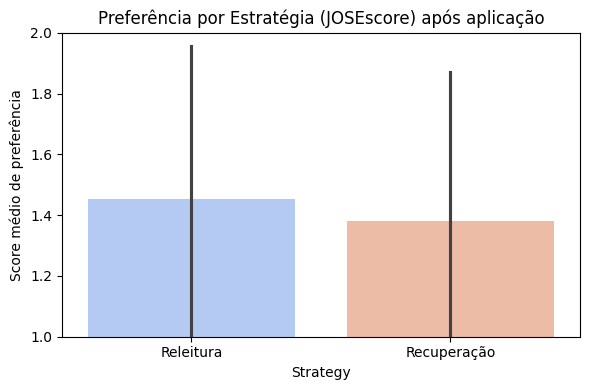

✅ Resultados salvos no Excel (aba: JOSE_by_strategy)


In [11]:
# ------------------- CELULA ANALÍTICA: Comparar JOSEscore por estratégia aplicada -------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pandas import ExcelWriter
import os

# Carregar e preparar dados
df = pd.read_csv(r"D:\PhD_Jupyter\files\data\clean_data\measures_phd_valid.csv")
df_valid = df[["Strategy", "JOSEscore"]].dropna()

# Grupos
group_restudy = df_valid[df_valid["Strategy"] == 0]["JOSEscore"]
group_retrieval = df_valid[df_valid["Strategy"] == 1]["JOSEscore"]

# Teste t independente
t_stat, p_val = ttest_ind(group_retrieval, group_restudy, equal_var=False)
mean_restudy = group_restudy.mean()
mean_retrieval = group_retrieval.mean()

print(f"Média JOSEscore - Releitura: {mean_restudy:.2f}")
print(f"Média JOSEscore - Retrieval Practice: {mean_retrieval:.2f}")
print(f"T = {t_stat:.3f}, p = {p_val:.4f}")
if p_val < 0.05:
    print("✅ Participantes que vivenciaram retrieval avaliaram essa estratégia como mais eficaz.")
else:
    print("⚠️ Diferença entre os grupos não foi estatisticamente significativa.")

# Gráfico
plt.figure(figsize=(6, 4))
sns.barplot(data=df_valid, x="Strategy", y="JOSEscore", ci="sd", palette="coolwarm")
plt.xticks([0, 1], ["Releitura", "Recuperação"])
plt.title("Preferência por Estratégia (JOSEscore) após aplicação")
plt.ylabel("Score médio de preferência")
plt.ylim(1, 2)
plt.tight_layout()

# Criar diretório e salvar gráfico
os.makedirs("D:/PhD_Jupyter/files/data/analysis", exist_ok=True)
plt.savefig("D:/PhD_Jupyter/files/data/analysis/plot_jose_by_strategy.png")
plt.show()

# Salvar dados no Excel
xlsx_path = "D:/PhD_Jupyter/files/data/analysis/analysis_results.xlsx"
df_valid.to_excel(xlsx_path, sheet_name="JOSE_by_strategy", index=False)
print("✅ Resultados salvos no Excel (aba: JOSE_by_strategy)")


In [12]:
# ------------------- CELULA ANALÍTICA: Comparar outros desfechos por Strategy -------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from pandas import ExcelWriter
import os

df = pd.read_csv(r"D:\PhD_Jupyter\files\data\clean_data\measures_phd_valid.csv")
outcomes = ["categorical_access", "words_recalled", "ARCscore"]  # Use 'ARCscore' if it exists; fallback to categorical_access

# Certifique-se de que os dados estão disponíveis
available = [o for o in outcomes if o in df.columns]
if not available:
    print("⚠️ Nenhum dos desfechos esperados encontrados.")
else:
    os.makedirs("D:/PhD_Jupyter/files/data/analysis", exist_ok=True)
    xlsx_path = "D:/PhD_Jupyter/files/data/analysis/analysis_results.xlsx"
    with ExcelWriter(xlsx_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        for var in available:
            subset = df[["Strategy", var]].dropna()
            restudy = subset[subset["Strategy"] == 0][var]
            retrieval = subset[subset["Strategy"] == 1][var]
            t, p = ttest_ind(retrieval, restudy, equal_var=False)
            mean0 = restudy.mean()
            mean1 = retrieval.mean()

            print(f"\n📊 Variável: {var}")
            print(f"Releitura média: {mean0:.2f} | Recuperação média: {mean1:.2f}")
            print(f"T = {t:.3f}, p = {p:.4f}")
            sig = "✅ Diferença significativa." if p < 0.05 else "⚠️ Sem significância estatística."
            print(sig)

            # Gráfico
            plt.figure(figsize=(5,4))
            sns.barplot(data=subset, x="Strategy", y=var, ci="sd", palette="Set2")
            plt.xticks([0, 1], ["Releitura", "Recuperação"])
            plt.title(f"{var} por Estratégia")
            plt.tight_layout()
            graph_path = f"D:/PhD_Jupyter/files/data/analysis/plot_{var}_by_strategy.png"
            plt.savefig(graph_path)
            plt.close()

            # Salvar dados no Excel
            subset.to_excel(writer, sheet_name=f"{var}_by_strategy", index=False)
            print(f"📁 Dados e gráfico salvos para: {var}")



📊 Variável: categorical_access
Releitura média: 6.42 | Recuperação média: 7.20
T = 3.506, p = 0.0007
✅ Diferença significativa.


C:\Users\cadu\AppData\Local\Temp\ipykernel_18240\1798520101.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subset, x="Strategy", y=var, ci="sd", palette="Set2")
C:\Users\cadu\AppData\Local\Temp\ipykernel_18240\1798520101.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="Strategy", y=var, ci="sd", palette="Set2")


📁 Dados e gráfico salvos para: categorical_access

📊 Variável: words_recalled
Releitura média: 20.36 | Recuperação média: 25.49
T = 3.415, p = 0.0009
✅ Diferença significativa.
📁 Dados e gráfico salvos para: words_recalled


C:\Users\cadu\AppData\Local\Temp\ipykernel_18240\1798520101.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=subset, x="Strategy", y=var, ci="sd", palette="Set2")
C:\Users\cadu\AppData\Local\Temp\ipykernel_18240\1798520101.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x="Strategy", y=var, ci="sd", palette="Set2")
